In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from tqdm import tqdm
from matplotlib.lines import Line2D

from cryptic_rnn import *

# Functions

In [29]:
def run_exp(trainseqs_old_b ,trainseqs_old_p, testseqs_old, cue_dict):

    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    input_vals.sort() # sort values (so A is smallest)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainset_b = []
    for trainb in trainseqs_old_b:
        trainseqs = change_dict(trainb, cue_dict)
        train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
        trainset_b.append(DataLoader(train_inputs, batch_size=batchsize, shuffle=True))
    
    trainset_p = []
    for trainp in trainseqs_old_p:
        trainseqs = change_dict(trainp, cue_dict)
        train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
        trainset_p.append(DataLoader(train_inputs, batch_size=batchsize, shuffle=True))

    testseqs = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers, xavier_gain)
    model_b = copy.deepcopy(model)
    model_p = copy.deepcopy(model)
    criterion = nn.MSELoss()
    
    optimizer = torch.optim.Adam(model_b.parameters(), lr=learningRate)
    lossb, accb = [], np.empty((0, 2))
    for trainb in trainset_b:
        loss_step, acc_step = run_acc(model_b,optimizer,criterion, trainb, [trainb, testset], epochs, hidden_size)
        lossb+=loss_step
        accb = np.vstack([accb, acc_step])
        
    optimizer = torch.optim.Adam(model_p.parameters(), lr=learningRate)
    lossp, accp = [], np.empty((0, 2))
    for trainp in trainset_p:
        loss_step, acc_step = run_acc(model_p,optimizer,criterion, trainb, [trainp, testset], epochs, hidden_size)
        lossp+=loss_step
        accp = np.vstack([accp, acc_step])
  
    return {'cue_dict':cue_dict, 'test': testset,
           'loss_b':lossb, 'acc_b':accb, 'mod_b': model_b,\
           'loss_p':lossp, 'acc_p':accp, 'mod_p': model_p,}

def run_plot(trainseqs_b, trainseqs_p,testseqs, cue_dict):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs_b, trainseqs_p,testseqs, cue_dict) for i in tqdm(range(num_sims)))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)
    
    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    
    losses_b = np.hstack([r['loss_b'] for r in res])
    acc_train_b = np.array([r['acc_b'][:,0] for r in res]).T
    acc_test_b = np.array([r['acc_b'][:,1] for r in res]).T
    mods_b = [r['mod_b'] for r in res]

    losses_p = np.hstack([r['loss_p'] for r in res])
    acc_train_p = np.array([r['acc_p'][:,0] for r in res]).T
    acc_test_p = np.array([r['acc_p'][:,1] for r in res]).T
    mods_p = [r['mod_p'] for r in res]
        
    plotNNs([losses_b], [acc_train_b, acc_test_b], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'balanced -no primitives', shift = 0)
    plotNNs([losses_p], [acc_train_p, acc_test_p], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'with primitives', shift = 0)

    plt.figure()
    r2_b, dfs_b, _ = predcorr(mods_b, tests, hidden_size, plot_corr =True)
    plt.title('balanced-without primitives; r^2 = '+ str(round(r2_b, 3)))
    plt.figure()
    r2_p, dfs_p, _ = predcorr(mods_p, tests, hidden_size, plot_corr = True)
    plt.title('with primitives; r^2 = '+ str(round(r2_p, 3)))

    acc_df = pd.DataFrame({'acc_train_b': acc_train_b[-1,:],'acc_train_p': acc_train_p[-1,:],\
                           'acc_test_b': acc_test_b[-1,:],'acc_test_p': acc_test_p[-1,:]})
    
    return {'mods_b':mods_b, 'mods_p':mods_p, \
            'res':res, 'tests': tests, 'cue_dicts': cue_dicts, 'acc_df':acc_df }

def extract_loss(res):
    losses = np.hstack([r['loss'] for r in res])
    losses_b = np.hstack([r['loss_b'] for r in res])
    losses_p = np.hstack([r['loss_p'] for r in res])
    losses_bp = np.hstack([r['loss_bp'] for r in res])
    return {'losses':losses, 'losses_b':losses_b,'losses_p':losses_p, 'losses_bp':losses_bp}

def extract_r2(res):
    tests = [r['test'] for r in res]
    mods = [r['mod'] for r in res]
    mods_b = [r['mod_b'] for r in res]
    mods_p = [r['mod_p'] for r in res]
    mods_bp = [r['mod_bp'] for r in res]

    r2, dfs, _ = predcorr(mods, tests, hidden_size, plot_corr = True)
    r2_b, dfs_b, _ = predcorr(mods_b, tests, hidden_size, plot_corr =True)
    r2_p, dfs_p, _ = predcorr(mods_p, tests, hidden_size, plot_corr = True)
    r2_bp, dfs_bp, _ = predcorr(mods_bp, tests, hidden_size, plot_corr =True)

def predcorr_ind_mod(mod, test, hidden_size, plot_corr = True):
    
    df = test_preds(mod, [test], hidden_size)
    preds, labs = df['pred'], df['label']
    r2_val = r2_score(preds,labs)
    
    return r2_val 
  
    
def plot_traincurve(res):
    
    losses = np.hstack([r['loss'] for r in res])
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test = np.array([r['acc'][:,1] for r in res]).T
    mods = [r['mod'] for r in res]
    
    losses_b = np.hstack([r['loss_b'] for r in res])
    acc_train_b = np.array([r['acc_b'][:,0] for r in res]).T
    acc_test_b = np.array([r['acc_b'][:,1] for r in res]).T
    mods_b = [r['mod_b'] for r in res]

    losses_p = np.hstack([r['loss_p'] for r in res])
    acc_train_p = np.array([r['acc_p'][:,0] for r in res]).T
    acc_test_p = np.array([r['acc_p'][:,1] for r in res]).T
    mods_p = [r['mod_p'] for r in res]
    
    losses_bp = np.hstack([r['loss_bp'] for r in res])
    acc_train_bp = np.array([r['acc_bp'][:,0] for r in res]).T
    acc_test_bp = np.array([r['acc_bp'][:,1] for r in res]).T
    mods_bp = [r['mod_bp'] for r in res]
    
    plotNNs([losses], [acc_train, acc_test], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'no primitives', shift = 0)
    plotNNs([losses_b], [acc_train_b, acc_test_b], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'balanced -no primitives', shift = 0)
    plotNNs([losses_p], [acc_train_p, acc_test_p], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'with primitives', shift = 0)
    plotNNs([losses_bp], [acc_train_bp, acc_test_bp], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'balanced - with primitives', shift = 0)

def plot_r2(res):
    
    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]

    mods = [r['mod'] for r in res]
    mods_b = [r['mod_b'] for r in res]
    mods_p = [r['mod_p'] for r in res]
    mods_bp = [r['mod_bp'] for r in res]
    
    plt.figure()
    r2, dfs, _ = predcorr(mods, tests, hidden_size, plot_corr = True)
    plt.title('without primitives; r^2 = '+ str(r2))
    plt.figure()
    r2_b, dfs_b, _ = predcorr(mods_b, tests, hidden_size, plot_corr =True)
    plt.title('balanced-without primitives; r^2 = '+ str(r2_b))
    plt.figure()
    r2_p, dfs_p, _ = predcorr(mods_p, tests, hidden_size, plot_corr = True)
    plt.title('with primitives; r^2 = '+ str(r2_p))
    plt.figure()
    r2_bp, dfs_bp, _ = predcorr(mods_bp, tests, hidden_size, plot_corr =True)
    plt.title('balanced-with primitives; r^2 = '+ str(r2_bp))
    

    
def calculate_RDMs(res, testseq, subset = 'ft'):
    
    acc_df = res['acc_df']
    if subset == 'ft':
        all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_b'] == 1)&\
                              (acc_df['acc_train_bp'] == 1) & (acc_df['acc_train_p'] == 1)].index
    elif subset == 'all':
        all_acc_mods = acc_df.index
    print('no. 100% trained RNNs: ', len(all_acc_mods))
    mod_list = all_acc_mods # choose subset of rnns 

    rdms = [[] for _ in range(4)] # initialise empty lists/arrays
    rdms_p = [[] for _ in range(4)]
    rdms_b = [[] for _ in range(4)] # initialise empty lists/arrays
    rdms_bp = [[] for _ in range(4)]
    # extracts results from dictionary
    mods = res['mods']
    mods_p = res['mods_p']
    mods_b = res['mods_b']
    mods_bp = res['mods_bp']

    cue_dicts = res['cue_dicts']
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model 

        testseqs = change_dict(testseq, cue_dicts[m])
        test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
        testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=False)

        # get activations for control model
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for h in range(4): 
            hid_vals = np.array([hid[h+1,:] for hid in hiddens]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms[h].append(rep_mat)

        # get activations for primitive trained model
        hiddens_p, trials = get_reps(mods_p[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h+1,:] for hid in hiddens_p])
            rep_mat = euclidean_distances(hid_vals)
            rdms_p[h].append(rep_mat)

        # get activations for control model
        hiddens_b, trials = get_reps(mods_b[m], [testset], hidden_size)
        for h in range(4): 
            hid_vals = np.array([hid[h+1,:] for hid in hiddens_b]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms_b[h].append(rep_mat)

        # get activations for primitive trained model
        hiddens_bp, trials = get_reps(mods_bp[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h+1,:] for hid in hiddens_bp])
            rep_mat = euclidean_distances(hid_vals)
            rdms_bp[h].append(rep_mat)
       
    return {'rdms': rdms, 'rdms_p': rdms_p, 'rdms_b': rdms_b, 'rdms_bp': rdms_bp, 'ft_cue_dicts': ft_cue_dicts}

def MDS_plot(matlist, testseqs, trainseqs, title = ''):
    
    valset = [t for t in testseqs if t not in trainseqs]
    valset_idx = [testseqs.index(val) for val in valset]
    
    colors2 = ['green', 'blue', 'orange', 'red']*4
    colors1 = ['green']*4 + ['blue']*4 + ['orange']*4 + [ 'red']*4
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=5, label='A + _'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='B + _'), 
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='C + _'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='D + _'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'green', markerfacecolor='none', markersize=10, label=' _ + A'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'blue',markerfacecolor='none', markersize=10, label=' _ + B'), 
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'orange',markerfacecolor='none', markersize=10, label=' _ + C'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'red',markerfacecolor='none', markersize=10, label=' _ + D')]
    
    
    plt.rcParams['figure.figsize'] = 6, 6
    fig, axs = plt.subplots(2,2)

    for j, dist in enumerate(matlist):
        mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
        X_transform = mds.fit_transform(dist)
        ax = axs[math.floor(j/2), j%2]
        ax.title.set_text('step: '+str(j+1))
        for i in range(len(testseqs)):
            if i in valset_idx:
                alph = 1
            else:
                alph = 0.2
            ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
            ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

    plt.suptitle('2D-MDS'+title)
    fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5)) 

def predcorr_violin(r2vals, labels=['without primitives', 'with primitives', 'balanced - without primitives', 'balanced - with primitives'],\
                    colors = ['blue', 'red', 'aqua', 'orange'], title = ''):
    
    all_r_sq = []
    training = []
    color_list = []
    for i, r2val_list in enumerate(r2vals):
        all_r_sq += r2val_list
        training += [labels[i]]*len(r2val_list)
        color_list += [colors[i]]*len(r2val_list)

    r_sq_scores = pd.DataFrame({'R_squared': all_r_sq, 'Training': training})
    x_data = np.append((np.array(steps) - 0.2), (np.array(steps) + 0.2))
    x_jittered = np.array(x_data) + np.random.normal(0,0.05,len(x_data))
    x_jittered = x_jittered - 1
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='without primitives'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='with primitives')] 

    fig, ax = plt.subplots(figsize= (8,5))
    violins = sns.violinplot(data=r_sq_scores, x="Training", y="R_squared", hue="Training",\
                             palette = ['white', 'white'])

    for x, y, color in zip(x_jittered, r_sq_scores["R_squared"], colors):
        ax.scatter(x, y, s = 20, color=color, alpha=0.2)

    plt.legend(handles=legend_elements)
    plt.title('Regression between model RDM and ground truth' + title)



## RNN params

In [3]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005
xavier_gain = 0.0001

## running params
epochs = 1800
num_sims = 200

In [9]:
def generate_pos_trials(op, input_ids, init_values, cue_dict, steps = 1):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat= steps))
    combi_ops = list(itertools.product(ops, repeat= steps))
    for init in input_ids:
        for cue in combi_inputcue:
            seq.append([('+',init),
                        *zip(combi_ops[0], cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_neg_trials(op, input_ids, init_values, cue_dict, steps = 1):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat= steps))
    combi_ops = list(itertools.product(ops, repeat= steps))
    for init in input_ids:
        for cue in combi_inputcue:
            seq.append([('-',init),
                        *zip(combi_ops[0], cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq


## Sequences

In [10]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print('cue_dict ',cue_dict)
pos_primitives = generate_pos_primitives(all_syms, cue_dict)
neg_primitives = generate_neg_primitives(all_syms, cue_dict)

trainseqs_add = generate_pos_other('+', all_syms[:-1], cue_dict)
trainseqs_sub = generate_neg_other('-', all_syms[:-1], cue_dict)

trainseqs_b1 = trainseqs_add + generate_balanced_primitives('+', all_syms, cue_dict)
trainseqs_b2 = trainseqs_b1 + generate_balanced_primitives('-', all_syms, cue_dict)
trainseqs_b = [trainseqs_b1, trainseqs_b2]

trainseqs_p1 = trainseqs_add  + pos_primitives
trainseqs_p2 = trainseqs_p1 + neg_primitives
trainseqs_p = [trainseqs_p1, trainseqs_p2]

print('trainseqs_b ',trainseqs_b)
print('trainseqs_p ',trainseqs_p)

testseqs_all = random.sample(generate_pos_trials(ops, all_syms, all_syms, cue_dict, steps = 2), 10) +\
               random.sample(generate_neg_trials('-', all_syms, all_syms, cue_dict, steps = 2), 10)
testseqs = testseqs
valset_idx = [idx for idx, seq in enumerate(testseqs_all) if seq not in trainseqs_b2]

print('testseqs ', testseqs )

cue_dict  {'A': 11, 'B': 6, 'C': 8, 'D': 4}
trainseqs_b  [[[('+', 'A'), ('+', 'B'), '=', 17], [('+', 'B'), ('+', 'C'), '=', 14], [('+', 'C'), ('+', 'A'), '=', 19], [('+', 'A'), ('+', 'C'), '=', 19], [('+', 'B'), ('+', 'D'), '=', 10]], [[('+', 'A'), ('+', 'B'), '=', 17], [('+', 'B'), ('+', 'C'), '=', 14], [('+', 'C'), ('+', 'A'), '=', 19], [('+', 'A'), ('+', 'C'), '=', 19], [('+', 'B'), ('+', 'D'), '=', 10], [('-', 'A'), ('-', 'C'), '=', -19], [('-', 'B'), ('-', 'D'), '=', -10]]]
trainseqs_p  [[[('+', 'A'), ('+', 'B'), '=', 17], [('+', 'B'), ('+', 'C'), '=', 14], [('+', 'C'), ('+', 'A'), '=', 19], [('+', 'A'), '=', 11], [('+', 'B'), '=', 6], [('+', 'C'), '=', 8], [('+', 'D'), '=', 4]], [[('+', 'A'), ('+', 'B'), '=', 17], [('+', 'B'), ('+', 'C'), '=', 14], [('+', 'C'), ('+', 'A'), '=', 19], [('+', 'A'), '=', 11], [('+', 'B'), '=', 6], [('+', 'C'), '=', 8], [('+', 'D'), '=', 4], [('-', 'A'), '=', -11], [('-', 'B'), '=', -6], [('-', 'C'), '=', -8], [('-', 'D'), '=', -4]]]
testseqs  [[('+',

In [9]:
random.sample(generate_pos_trials(ops, all_syms, all_syms, cue_dict, steps = 2), 10)

[[('+', 'A'), ('+', 'B'), ('+', 'D'), '=', 20],
 [('+', 'B'), ('+', 'B'), ('+', 'D'), '=', 21],
 [('+', 'B'), ('+', 'A'), ('+', 'B'), '=', 26],
 [('+', 'A'), ('+', 'C'), ('+', 'A'), '=', 23],
 [('+', 'B'), ('+', 'D'), ('+', 'C'), '=', 19],
 [('+', 'C'), ('+', 'B'), ('+', 'D'), '=', 19],
 [('+', 'B'), ('+', 'A'), ('+', 'C'), '=', 24],
 [('+', 'B'), ('+', 'D'), ('+', 'B'), '=', 21],
 [('+', 'D'), ('+', 'D'), ('+', 'B'), '=', 15],
 [('+', 'C'), ('+', 'A'), ('+', 'A'), '=', 23]]

100%|███████████████████████████████████████████| 16/16 [02:14<00:00,  8.40s/it]


run time:  4.2496736685434975


/Users/miahannah/compositional_learning_MW/_run_RNNs/cryptic_rnn.py:576: RuntimeWarning: Mean of empty slice.
  mn = arr.mean(axis=1)
/Users/miahannah/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/miahannah/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/miahannah/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/miahannah/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


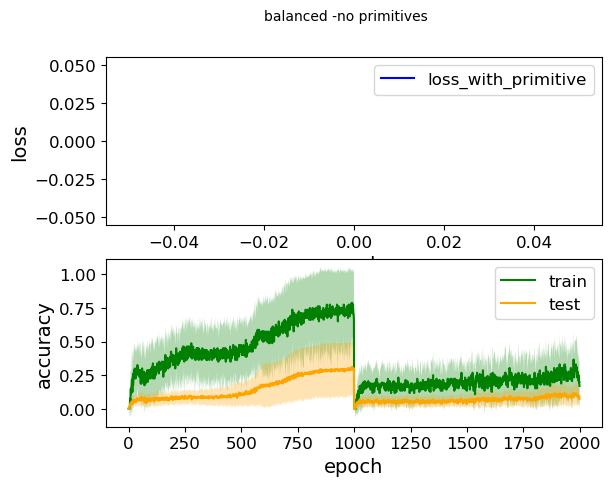

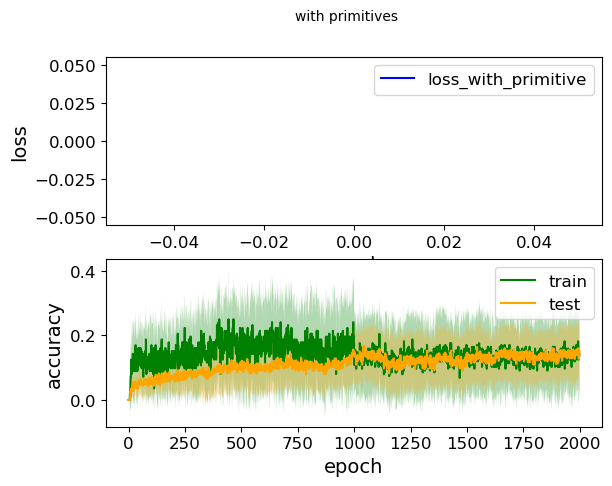

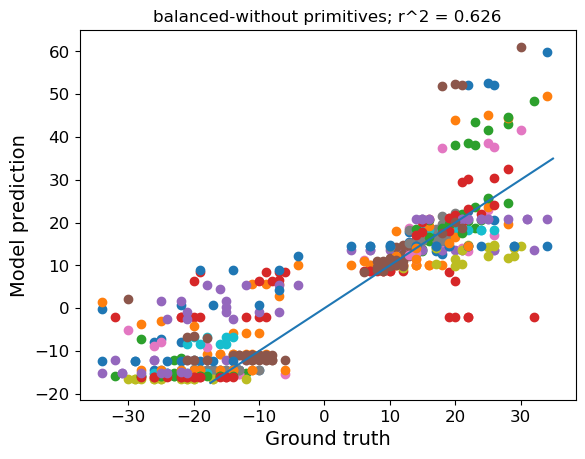

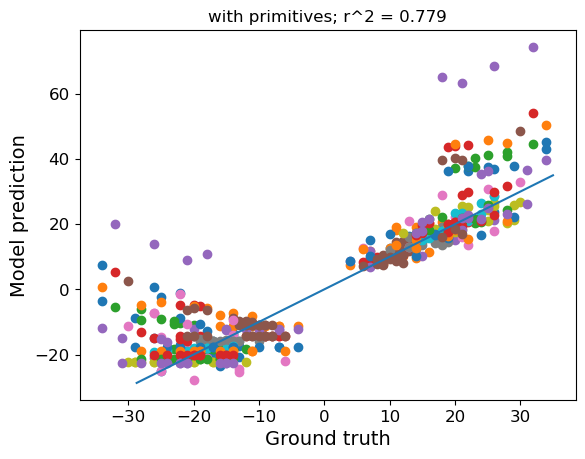

In [32]:
epochs = 1000
num_sims = 16
res_3input_corrected_200 = run_plot(trainseqs_b, trainseqs_p, testseqs, cue_dict)

In [15]:
save_dir = '../results/corrected/addition_trigrams_3inputs_bp_800'
with open(save_dir, 'wb') as f:
    pickle.dump(res_3input_corrected, f)


In [33]:
save_dir = '../results/corrected/addition_trigrams_3inputs_bp_800'
with open(save_dir, 'rb') as f:
    res1 = pickle.load(f)


In [39]:
all_loss = [r['loss'][-1] for r in res1['res']]

In [43]:
np.mean(all_loss)

0.04375306106832994

In [14]:
!pwd


/Users/miahannah/compositional_learning_MW/_run_RNNs


In [215]:
# save_dir = '../results/addition_trigrams_3inputs_bp_800'
# with open(save_dir, 'rb') as f:
#     res1 = pickle.load(f)


In [211]:
#res_4input_2['acc_df']


,acc_train,acc_train_b,acc_train_p,acc_train_bp,acc_test,acc_test_b,acc_test_p,acc_test_bp
0,1.0,0.0,1.000000,1.0,0.000000,0.000000,0.769231,0.769231
1,1.0,1.0,1.000000,1.0,0.153846,1.000000,1.000000,1.000000
2,1.0,1.0,1.000000,1.0,0.153846,0.846154,0.307692,0.692308
3,1.0,1.0,1.000000,1.0,0.153846,0.769231,1.000000,1.000000
4,1.0,0.0,1.000000,1.0,0.000000,0.000000,0.538462,0.307692
...,...,...,...,...,...,...,...,...
195,1.0,1.0,1.000000,1.0,0.153846,1.000000,0.769231,0.692308
196,1.0,1.0,1.000000,1.0,0.153846,1.000000,0.692308,0.769231
197,1.0,1.0,0.857143,1.0,0.153846,1.000000,0.384615,0.384615
198,1.0,1.0,0.857143,1.0,0.000000,1.000000,0.384615,0.692308


In [216]:
combi_dict = {'mods':res1['mods']+res_4input_2['mods'],
              'mods_b':res1['mods_b']+res_4input_2['mods_b'],
              'mods_p':res1['mods_p']+res_4input_2['mods_p'],
              'mods_bp':res1['mods_bp']+res_4input_2['mods_bp'],
              'res':res1['res']+res_4input_2['res'],
              'tests':res1['tests']+res_4input_2['tests'],
              'cue_dicts':res1['cue_dicts']+res_4input_2['cue_dicts'],
              'acc_df':pd.concat([res1['acc_df'], res_4input_2['acc_df']])}

In [217]:
savedir = '../results/addition_trigrams_3inputs_bp_1000'

with open(savedir, 'wb') as f:
    pickle.dump(combi_dict, f)
f.close()

In [219]:
save_dir = '../results/addition_trigrams_3inputs_bp'
with open(save_dir, 'rb') as f:
    res1 = pickle.load(f)


100%|█████████████████████████████████████████| 100/100 [58:38<00:00, 35.18s/it]


run time:  65.53950578371683


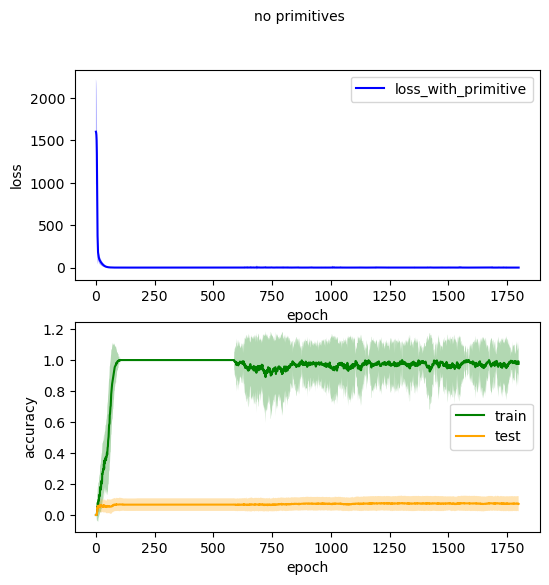

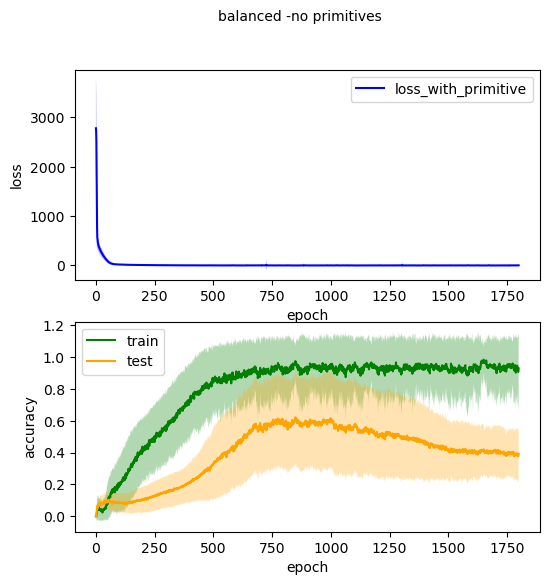

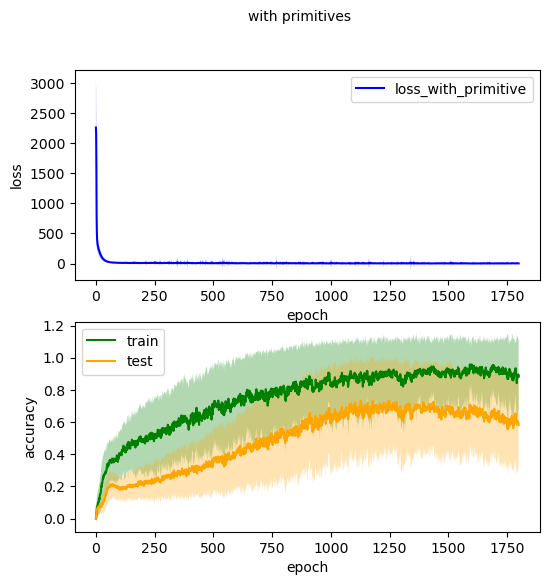

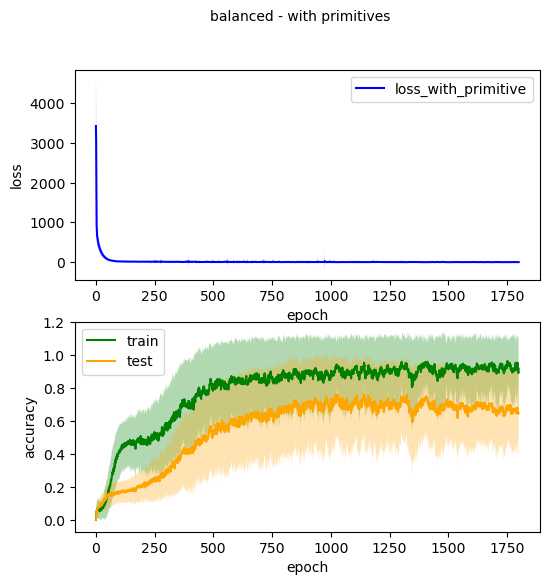

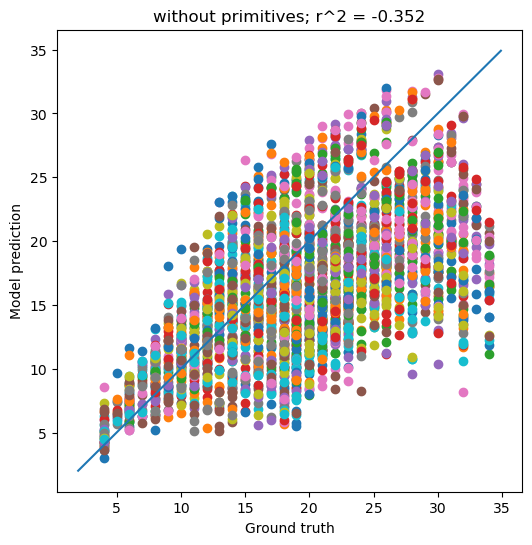

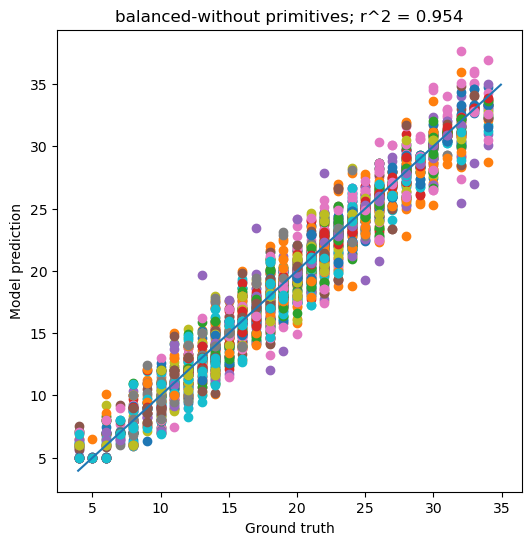

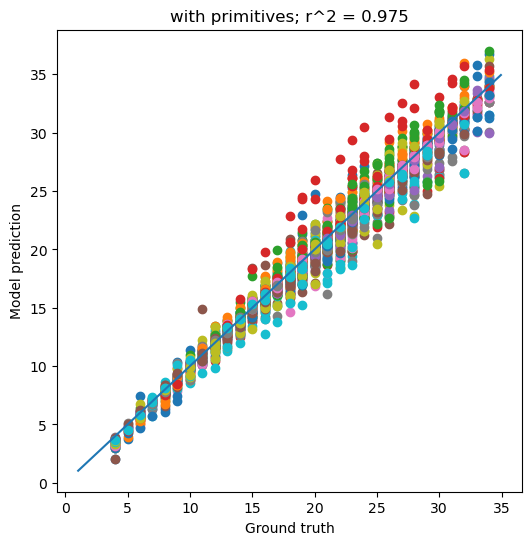

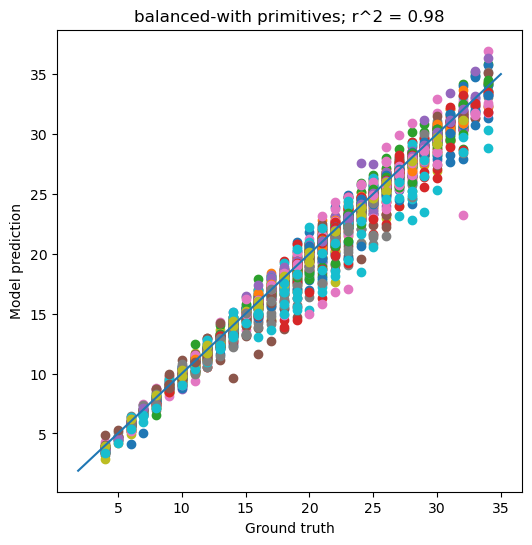

In [19]:
hidden_size = 20

num_sims = 100
res_6 = run_plot(trainseqs, trainseqs_b, trainseqs_p, trainseqs_bp, testseqs, cue_dict)

In [21]:
res_rdm = calculate_RDMs(res_6, testseqs_all, subset='all')

rdms = res_rdm['rdms']
rdms_p = res_rdm['rdms_p']
rdms_b = res_rdm['rdms_b']
rdms_bp = res_rdm['rdms_bp']
cue_dicts = res_rdm['ft_cue_dicts']
matlist = [np.array(rdms[t]).mean(axis=0) for t in range(4)]
matlist_p = [np.array(rdms_p[t]).mean(axis=0) for t in range(4)]
matlist_b = [np.array(rdms_b[t]).mean(axis=0) for t in range(4)]
matlist_bp = [np.array(rdms_bp[t]).mean(axis=0) for t in range(4)]

no. 100% trained RNNs:  100


dict_keys(['mods', 'mods_b', 'mods_p', 'mods_bp', 'res', 'tests', 'cue_dicts', 'acc_df'])

In [309]:
i = random.randint(1,300)
my_mod = res1['mods'][i]
cue_dict = res1['cue_dicts'][i]

In [310]:
my_mod

OneStepRNN(
  (rnn): RNN(22, 20, batch_first=True)
  (input2hidden): Linear(in_features=42, out_features=20, bias=True)
  (fc1tooutput): Linear(in_features=20, out_features=1, bias=True)
)

In [311]:
primseqs = change_dict(primitives, cue_dict)
test_inputs = convert_seq2inputs(primseqs, num_classes=num_classes, seq_len=5)
primset = DataLoader(test_inputs, batch_size=batchsize, shuffle=False)


In [312]:
my_mod.eval()
preds=[]
labs=[]
for testset in [primset]:
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = my_mod.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())


In [313]:
preds

[1.835428237915039, 4.780693054199219, 5.200282096862793, 3.2218375205993652]

In [314]:
labs

[3.0, 5.0, 13.0, 16.0]

In [315]:
primseqs

[[('+', 'A'), '=', 3],
 [('+', 'B'), '=', 5],
 [('+', 'C'), '=', 13],
 [('+', 'D'), '=', 16]]